# 神经网络学习
在本练习中，你将实现神经网络的反向传播算法，并将其应用于手写数字识别任务。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize # 使用 fmin_cg 用来训练神经网络
import itertools
import scipy.io      # 用来载入 OCTAVE *.mat 文件
import matplotlib.cm as cm      # 用于在特定颜色映射中显示图像
import random        # 为了随机选择图片显示
from scipy.special import expit # 向量化的sigmod函数
from PIL import Image # 用于图片处理

## 1 神经网络
在上一个练习中，你实现了神经网络的前向传播算法，并使用它来预测我们提供的权重的手写数字。在本练习中，你将实现反向传播算法以学习神经网络的参数。
### 1.1 数据可视化
这里用到的是和之前练习相同的数据集，ex4data1.mat中有5000个训练示例，其中每个训练示例是手写数字的20像素乘20像素灰度图像。   
每个像素由浮点数表示，该浮点数表示该位置处的灰度强度。 20×20像素网格被“展开”成400维向量。   
这些训练样例中的每一个变成了我们的数据矩阵X的中一行。这里给出了5000乘400矩阵X，其中每行都是一个手写数字图像的训练示例。  
$$ X = 
\begin{bmatrix} 
-\ (x^{(1)})^T\ -\\
-\ (x^{(2)})^T\ -\\
...\\
-\ (x^{(m)})^T\ - 
\end{bmatrix} \quad $$
训练集的第二部分是5000维向量y，包含训练集的标签。 为了兼容Octave / MATLAB索引，没有零索引。   
因此，手写数字“0”标记为“10”，而数字“1”到“9”按其自然顺序标记为“1”到“9”。

In [2]:
datafile="ex4data1.mat"
mat = scipy.io.loadmat(datafile)
X, y = mat["X"], mat["y"]
X = np.insert(X,0,1,axis=1) # 照常给矩阵X插入一列“1”
print ("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s" %(X.shape,X[0].shape))
#X 是 5000 个图片. 每个图片是一行. 每个图片有400像素(20x20)
#y 是每个图片的类别. 1-10, 10代表手写数字“0”

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [3]:
def getDatumImg(row):
    """
    从X矩阵获取1x400的一行数组，转化成20x20的图片数组并返回
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    从X矩阵随机获取100行，从每行创建出一个20x20的图片，然后把它们拼接成10x10网格的图像并显示
    """
    width, height = 20, 20 # 每个小图片的宽，高
    nrows, ncols = 10, 10  # 小图片行数列数
    show_y = False # 是否显示y的值
    
    # 如果没有指定要显示的图像，就随机从X矩阵中选择 nrows*ncols 个图像进行显示
    if not indices_to_display: 
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)  # indices_to_display 是随机从X矩阵中选择的行数
        show_y = True
         
    big_picture = np.zeros((height*nrows,width*ncols))
    pic_y=np.zeros((nrows,ncols))
    
    # 对于每一行，插入10个小图，然后切换到下一行，直到完成第10行
    irow, icol = 0, 0 # 正在添加的小图片的行数和列数
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[ irow*height: irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        pic_y[irow,icol]=0 if y[idx]==10 else y[idx]
        icol += 1
        
    big_picture *= 255     # Imag.fromarray不适用原数据，无法显示，转化一下
    img = Image.fromarray(big_picture)
    
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap="gray")
    
    if show_y:
        print(pic_y)

[[8. 7. 7. 5. 0. 2. 5. 7. 5. 7.]
 [7. 7. 0. 3. 9. 8. 7. 1. 3. 5.]
 [8. 8. 4. 4. 5. 1. 8. 8. 2. 9.]
 [1. 7. 6. 4. 9. 8. 6. 8. 1. 3.]
 [8. 9. 4. 4. 3. 6. 2. 1. 8. 9.]
 [6. 8. 0. 5. 4. 6. 3. 7. 1. 6.]
 [2. 1. 2. 2. 6. 4. 1. 5. 6. 9.]
 [1. 5. 1. 7. 1. 8. 1. 1. 5. 2.]
 [1. 4. 6. 7. 1. 1. 5. 7. 3. 7.]
 [5. 3. 7. 7. 8. 2. 3. 0. 4. 6.]]


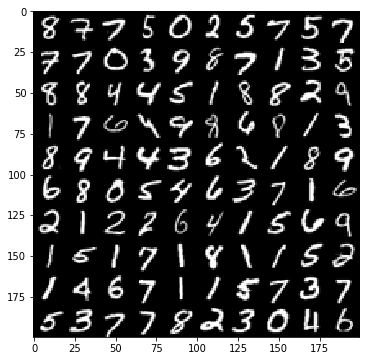

In [4]:
displayData()

### 1.2 模型表示
我们的神经网络如Figure 2所示。它有3层 - 输入层，隐藏层和输出层。 回想一下，我们的输入是数字图像的像素值。 由于图像大小为20×20，因此我们得到400个输入层单元（不包括总是输出+1的额外偏置单元）。 和以前一样，训练数据将被加载到变量X和y中。 
<img src="docimg/fig2.png">
<center>Figure2 神经网络模型</center>  
  
  
你已经获得了我们已经培训得到的一组神经网络参数(Θ(1),Θ(2))。 它们存储在ex4weights.mat中，并加载到Theta1和Theta2中。参数的大小适合神经网络，第二层有25个单元，10个输出单元（对应10个数字类）。

In [5]:
# 载入给出的theta参数
datafile="ex4weights.mat"
mat = scipy.io.loadmat(datafile)
Theta1, Theta2 = mat["Theta1"], mat["Theta2"]
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26

In [6]:
# 一些全局变量，以确保各种矩阵的大小是正确的，这些变量不包括偏置单位
input_layer_size = 400 # 输入层单元数
hidden_layer_size = 25 # 隐藏层
output_layer_size = 10 # 输出层
n_training_samples = X.shape[0] # 训练样本大小

In [7]:
# 一些工具方法
# 对于θ矩阵，输入X矩阵等有很多展开和形状重塑操作。
# 良好形状的矩阵使得线性代数在开发时更容易，但最小化方法（fmin_cg）要求所有输入

# theta的平整化和重塑形状
def flattenParams(thetas_list):
    """
    输入一个theta矩阵的列表，将会返回一个平整化后（n,1）形状的numpy数组
    """
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    """
    输入一个平整化的theta数组，返回一个theta矩阵列表
    """
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

# X矩阵的平整化和重塑形状
def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

### 1.3 前向传播与代价函数
现在，你需要为神经网络实现代价函数和梯度函数。  
回想一下，神经网络的代价函数（无正则化）为
$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K\big[-y_k^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(x^{(i)}))_k)\big]$$  
其中$h_\theta(x^{(i)})$的计算如Figure 2 中所示，K = 10是可能的标签总数。注意，$h_\theta(x^{(i)})_k = a^{(3)}_k$ 是第k个输出单元的激活项（输出值）。此外，回想一下，虽然原始标签（在变量y中）是1,2，...，10，为了训练神经网络，我们需要将标签重新编码为仅包含值0或1的向量，所以
$$y=
\begin{bmatrix}
1\\
0\\
0\\
...\\
0
\end{bmatrix},\ 
\begin{bmatrix}
0\\
1\\
0\\
...\\
0
\end{bmatrix},\ ...\ or\ 
\begin{bmatrix}
0\\
0\\
0\\
...\\
1
\end{bmatrix}.$$
例如，如果$x^{(i)}$是数字5的图像，那么相应的$y^{(i)}$（你应该使用成本函数）应该是一个10维向量，$y_5$ = 1，其他元素都为0。你应该为每个示例 i 实现计算 $h_\theta(x^{(i)})$ 的前馈计算，并对所有示例的成本求和。你的代码也应该适用于任何大小的数据集，包含任意数量的标签（你可以假设总是至少有K≥3个标签）。
完成后，使用Theta1和Theta2的加载参数集调用nnCostFunction。 您应该看到成本约为0.287629。

In [12]:
def computeCost(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    """
    输入：         
        1）theta参数的展开向量（每个theta将从1个神经网络层到达下一层），其中包括偏置单元。         
        2）展开的训练集矩阵X，其包含偏置单元第一列         
        3）标签向量y，为一列     
    遍历循环所有训练点（由教授推荐，作为线性代数版本“非常复杂”）和：         
        1）构造一个新的“y”向量，具有10行和1列，其中一个非零条目对应于该迭代      
        2）计算给定y-向量和训练点的成本         
        3）积累所有代价         
        4）计算正则化项（在训练点循环之后）
    """
    
    # 首先展开参数theta
    mythetas = reshapeParams(mythetas_flattened)
    
    # 展开X矩阵
    myX = reshapeX(myX_flattened)
    
    # 总代价
    total_cost = 0.
    
    m = n_training_samples

    # 遍历训练点 (myX, 包含偏置项)
    for irow in range(m):
        myrow = myX[irow]
                
        # 首先计算假设（这是关于每个可能的y值的假设的（10,1）向量）
        # propagateForward方法为每个层返回（zs，激活项），因此 propagateForward[-1][1]表示“最后一层的激活项”
        myhs = propagateForward(myrow,mythetas)[-1][1]

        # 构造一个10x1 的“y”向量 ,其中只有一个项为“1”其他都是“0”
        # 注意，如果手写数字为“0”，则对应于第10个位置为1的y向量（与作业建议的不同）
        tmpy  = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        
        # 计算此假设和y向量的代价
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # 累加代价
        total_cost += mycost
  
    # 规格化total_cost,转换成float
    total_cost = float(total_cost) / m
    
    # 计算正则化项
    total_reg = 0.
    if mylambda != 0:
        for mytheta in mythetas:
            total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
        total_reg *= float(mylambda)/(2*m)
        
    return total_cost + total_reg
       

def propagateForward(row,Thetas):
    """
    此方法输入一个Thetas列表（未展开），向前传播特征行，假定Thetas和输入层的特征行都已包含偏置项，
    
    对于隐藏层输出一个元素为[0]的向量，对输出层输出元素为[1]的向量
        --每个元素都是一个（zs,as）的元组
        --其中"zs"和"as"的形状为（本层的单元数，1）
        
    激活项与“h”相同，但这适用于许多层（因此是一个thetas的矢量，而不仅仅是一个theta）
    此外，“h”被矢量化以一次性完成所有行    
    这个函数一次只使用一行
    """
    features = row
    zs_as_per_layer = []
    for i in range(len(Thetas)):  
        Theta = Thetas[i]
        # Theta 的形状为(25,401),特征为(401,1)
        # 所以"z"的形状为（25,1）
        # 在隐藏层的每个单元都有一个"z"值相对应
        # 未计算偏置项
        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [13]:
# 使用载入的Theta1和Theta2算得代价约为0.287629

myThetas = [ Theta1, Theta2 ]

# 注意：我根据computeCost函数的输入格式将thetas向量展平，
# 然后将其传递给computeCost例程。
# 它会自动展开/重新整形。同样的，我也将X向量展平。
print (computeCost(flattenParams(myThetas),flattenX(X),y))

0.2876291651613188


### 1.4 正则化的代价函数
正则化的神经网络代价函数为：
$$J(\theta)=\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^K\big[-y_k^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y_k^{(i)})log(1-(x^{(i)}))_k)\big]+
\frac{\lambda}{2m}\Big[\sum\limits_{j=1}^{25}\sum\limits_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum\limits_{j=1}^{10}\sum\limits_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\Big].$$  
你可以假设神经网络只有3层：输入层、隐藏层和输出层，但是你的代码适用于任意数量的输入单元、中间单元和输出单元。虽然为了清楚起见，在上式中我们已明确列出了 $\Theta^{(1)}$ 和 $\Theta^{(2)}$ 的上述索引，但请注意，**您的代码通常应适用任何大小的 $\Theta^{(1)}$ 和 $\Theta^{(2)}$** 。   
请注意，您不应该将与偏置项相对应的项正则化。 对于矩阵Theta1和Theta2，这对应于每个矩阵的第一列。 您现在应该将正则化添加到代价函数中。 请注意，您可以先使用现有的nnCostFunction.m计算未经规范的成本函数J，然后再添加正则化项的成本。 完成后，使用Theta1和Theta2的加载参数集调用nnCostFunction，并且λ= 1.您应该看到代价约为0.383770。

In [14]:
# 应该看到代价约为0.383770
myThetas = [ Theta1, Theta2 ]
print (computeCost(flattenParams(myThetas),flattenX(X),y,mylambda=1.))

0.38448779624289386


## 2. 反向传播算法
在本练习的这一部分中，您将实现反向传播算法来计算神经网络代价函数的梯度。您需要完成nnCostFunction.m，以便为grad返回适当的值。计算出梯度后，您将能够通过使用高级优化器（如fmincg）最小化成本函数 $J(\Theta)$ 来训练神经网络。  
您将首先实现反向传播算法来计算（未正则化的）神经网络的参数的梯度。在你验证了非正则化案例的梯度计算是正确的之后，你将实现正则化神经网络的梯度。
#### 2.1 对数梯度
为了帮助你完成这部分的内容，你首先要实现对数梯度方法，当
$$sigmoid(z)=g(z)=\frac{1}{1+e^{-z}}\ \ 时，$$
对数函数的梯度可以像这样计算
$$g'(z)=\frac{d}{dz}g(z)=g(z)(1-g(z))$$

In [ ]:
def SigmoidGradient(z):
    dummy=expit(z)
    return dummy*(1-dummy)

#### 2.2 随机初始化
当训练神经网络时，为了打破对称性，随机初始化时非常重要的。一个随机初始化的有效方法是在$[-\epsilon_{init},\epsilon_{init} ]$中为$\Theta^{(l)}$随机选择值。你应该让$\epsilon_{init}=0.12$。这样的值范围可以保证参数足够小并使学习更有效。  
你的任务是完成 randInitializeWeights 方法来初始化$\Theta$的权重

In [ ]:
def randInitializeWeights():
    epsilon_init=0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 反向传播
现在，你要实现反向传播算法。